In [ ]:
!pip install PBC4cip

     |████████████████████████████████| 57 kB 1.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np

#Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Modify PBC4cip implementation
from PBC4cip.core.PBC4cip import PBC4cip
from PBC4cip.core.Dataset import Dataset, FileDataset, PandasDataset
from PBC4cip.core.DecisionTreeBuilder import DecisionTreeBuilder, MultivariateDecisionTreeBuilder
from PBC4cip.core.PatternMiner import PatternMinerWithoutFiltering
from PBC4cip.core.DistributionEvaluatorHelper import get_distribution_evaluator
# Child for DecisionTreeBuilder
from PBC4cip.core.DecisionTreeBuilder import DecisionTreeBuilder
from PBC4cip.core.Helpers import combine_instances, ArgMax
from PBC4cip.core.DistributionTester import PureNodeStopCondition
from PBC4cip.core.SplitIterator import SplitIteratorProvider

## PBC4cip

In [ ]:
# New child class from DecisionTreeBuilder
class DTB(DecisionTreeBuilder):
    # Adds max_depth and min_obj_leaf to constructor
    def __init__(self, dataset, X, y, max_depth=-1, min_obj_leaf=2):
        self.__MinimalInstanceMembership = 0.05
        self.__MinimalSplitGain = 1e-30
        # Min Leaf
        self.__MinimalObjByLeaf = min_obj_leaf
        # Max depth
        self.__MaxDepth = max_depth
        self.__PruneResult = False
        self.__Dataset = dataset
        self.__trainInstances = combine_instances(X, y)
        self.__FeatureCount = 0
        self.__StopCondition = PureNodeStopCondition
        self.__distributionEvaluator = None
        self.__OnSelectingFeaturesToConsider = None
        self.__SplitIteratorProvider = SplitIteratorProvider(self.Dataset)
    
    @property
    def Dataset(self):
        return self.__Dataset
    @Dataset.setter
    def Dataset(self, new_dataset):
        self.__Dataset = new_dataset
    
    @property
    def MinimalObjByLeaf(self):
        return self.__MinimalObjByLeaf
    @MinimalObjByLeaf.setter
    def MinimalObjByLeaf(self, new_MinimalObjByLeaf):
        self.__MinimalObjByLeaf = new_MinimalObjByLeaf
    
    @property
    def MinimalInstanceMembership(self):
        return self.__MinimalInstanceMembership
    
    @property
    def StopCondition(self):
        return self.__StopCondition
    
    @property
    def SplitIteratorProvider(self):
        return self.__SplitIteratorProvider
    
    @property
    def FeatureCount(self):
        return self.__FeatureCount
    @FeatureCount.setter
    def FeatureCount(self, new_feature_count):
        self.__FeatureCount = new_feature_count
    
    @property
    def MaxDepth(self):
        return self.__MaxDepth
    @MaxDepth.setter
    def MaxDepth(self, new_MaxDepth):
        self.__MaxDepth = new_MaxDepth
    
    @property
    def distributionEvaluator(self):
        return self.__distributionEvaluator

    @distributionEvaluator.setter
    def distributionEvaluator(self, new_distributionEvaluator):
        self.__distributionEvaluator = new_distributionEvaluator
    
    @property
    def MinimalSplitGain(self):
        return self.__MinimalSplitGain
    @MinimalSplitGain.setter
    def MinimalSplitGain(self, new_minimal_split_gain):
        self.__MinimalSplitGain = new_minimal_split_gain
    
    @property
    def trainInstances(self):
        return self.__trainInstances
    @trainInstances.setter
    def trainInstances(self, new_train_instances):
        self.__trainInstances = new_train_instances
    
    def __FillNode(self, node, instanceTuples, level, currentContext):
        #print(f"nodeData: {node.Data}")
        if self.StopCondition(node.Data, self.Dataset.Model, self.Dataset.Class):
            return
        if self.MaxDepth >= 0 and (level >= self.MaxDepth - 1):
            return
        if sum(node.Data) <= self.MinimalObjByLeaf:
            return
        
        whichBetterToFind = 1
        winningSplitSelector = WinningSplitSelector(whichBetterToFind)
        attr = self.Dataset.Attributes
        
        sampleFeatures = self.OnSelectingFeaturesToConsider(
            list(map(lambda attribute: attribute[0], attr)), self.FeatureCount)
        if isinstance(self.distributionEvaluator, types.FunctionType):
            for feature in sampleFeatures:
                if feature != self.Dataset.Class[0]:
                    splitIterator = self.SplitIteratorProvider.GetSplitIterator(feature)
                    splitIterator.Initialize(instanceTuples)
                    while splitIterator.FindNext():
                        currentGain = self.distributionEvaluator(
                            node.Data, splitIterator.CurrentDistribution)
                        if currentGain >= self.MinimalSplitGain:
                            winningSplitSelector.EvaluateThis(
                                currentGain, splitIterator)

        else:
            for feature in sampleFeatures:
                if feature != self.Dataset.Class[0]:
                    splitIterator = self.SplitIteratorProvider.GetSplitIterator(feature)
                    splitIterator.Initialize(instanceTuples)
                    while splitIterator.FindNext():
                        self.distributionEvaluator.add_candidate_splits(node.Data, splitIterator.CurrentDistribution)

            winning_split_index = self.distributionEvaluator.get_best_split_idx()
            idx = 0
            for feature in sampleFeatures:
                if feature != self.Dataset.Class[0]:
                    splitIterator = self.SplitIteratorProvider.GetSplitIterator(feature)
                    splitIterator.Initialize(instanceTuples)
                    while splitIterator.FindNext():
                        if idx == winning_split_index:
                            winningSplitSelector.List = list(tuple())
                            winningSplitSelector.EvaluateThis(None, splitIterator)
                        idx = idx + 1
                
        if winningSplitSelector.IsWinner():
            maxSelector = winningSplitSelector.WinningSelector
            node.ChildSelector = maxSelector
            node.Children = list()
            instancesPerChildNode = CreateChildrenInstances(
                instanceTuples, maxSelector, self.MinimalInstanceMembership)

            for index in range(maxSelector.ChildrenCount):
                childNode = DecisionTreeNode(winningSplitSelector.WinningDistribution[index])
                childNode.Parent = node
                node.Children.append(childNode)

                self.__FillNode(
                    childNode, instancesPerChildNode[index], level + 1, currentContext)

        return

In [ ]:
# Apply new class DTB in new PBC4cip
class NewPBC4cip(PBC4cip):
    def __init__(self, tree_count=100, distribution_evaluator='quinlan gain', file_dataset = None, max_depth=-1, min_obj_leaf=2):
        self.File = None
        self.__miner = None
        self.__treeCount = tree_count
        if file_dataset is not None:
            self.__dataset = FileDataset(file_dataset)
        else:
            self.__dataset = None
        self.__EmergingPatterns = list()
        self.__class_nominal_feature = None
        self.__normalizing_vector = None
        self.__distribution_evaluator = get_distribution_evaluator(distribution_evaluator)
        self.__votesSum = None
        self.__classDistribution = None
        self.__max_depth = max_depth
        self.__min_obj_leaf = min_obj_leaf
    
    @property
    def max_depth(self):
        return self.__max_depth

    @max_depth.setter
    def max_depth(self, new_maxdepth):
        self.__max_depth = new_maxdepth
    
    @property
    def min_obj_leaf(self):
        return self.__min_obj_leaf

    @min_obj_leaf.setter
    def min_obj_leaf(self, new_min_obj_leaf):
        self.__min_obj_leaf = new_min_obj_leaf
    
    @property
    def dataset(self):
        return self.__dataset

    @dataset.setter
    def dataset(self, new_dataset):
        self.__dataset = new_dataset
    
    @property
    def miner(self):
        return self.__miner

    @miner.setter
    def miner(self, new_miner):
        self.__miner = new_miner
        
    @property
    def treeCount(self):
        return self.__treeCount

    @treeCount.setter
    def treeCount(self, new_treeCount):
        self.__treeCount = new_treeCount
    
    @property
    def distribution_evaluator(self):
        return self.__distribution_evaluator

    @distribution_evaluator.setter
    def distribution_evaluator(self, new_distribution_evaluator):
        self.__distribution_evaluator = new_distribution_evaluator
    
    # Replace DecisionTreeBuilder with DTB
    def fit(self, X, y):
        if not isinstance(self.dataset, FileDataset):
            self.dataset = PandasDataset(X,y)
            X = X.to_numpy()
            y = y.to_numpy()
            if  not isinstance(y[0], np.ndarray):
                y = convert_to_ndarray(y)    

        self.miner = PatternMinerWithoutFiltering()
        miner = self.miner
        miner.dataset = self.dataset
        miner.TreeCount = self.treeCount
        # Adds extra parameters
        miner.decisionTreeBuilder = DTB(self.dataset, X, y, self.max_depth, self.min_obj_leaf)
        miner.decisionTreeBuilder.distributionEvaluator = self.distribution_evaluator
        self.EmergingPatterns = miner.Mine()
        self.__ComputeVotes(X, y, self.dataset.Class[1])
        return self.EmergingPatterns
    
    def __predict_inst(self, instance):
        votes = [0]*len(self._class_nominal_feature)

        for pattern in self.EmergingPatterns:
            if pattern.IsMatch(instance):
                for i in range(len(votes)):
                    votes[i] += pattern.Supports[i]

        result = [0]*(len(votes)) 
        for i,_ in enumerate(votes):
            try:
                result[i] = votes[i] * \
                    self._normalizing_vector[i] / self.__votesSum[i]
            except ZeroDivisionError:
                result[i] = 0

        if sum(result) > 0:
            return result
        else:
            return self.__classDistribution
    
    def predict(self, X):
        scored_samples = self.score_samples(X)  
        predicted = [ArgMax(instance) for instance in scored_samples]
        return predicted
    
    def score_samples(self, X):
        if isinstance(self.dataset, PandasDataset):
            X = X.to_numpy()

        classification_results = list()
        for instance in tqdm(X, desc=f"Classifying instances", unit="instance", leave=False):
            result = self.__predict_inst(instance)
            classification_results.append(result)

        return classification_results

    
    def __ComputeVotes(self, X, y, classes):
        self._class_nominal_feature = classes
        instancesByClass = self.__GroupInstancesByClass(
            X, y, classes)
        self._normalizing_vector = self.__ComputeNormalizingVector(
            instancesByClass, len(y))
        self.__classDistribution = self.__ComputeClassDistribution(
            instancesByClass,  len(y))

        self.__votesSum = [0]*len(classes)
        for pattern in self.EmergingPatterns:
            for i,_ in enumerate(classes):
                self.__votesSum[i] += pattern.Supports[i]

    def __GroupInstancesByClass(self, X, y, classes):
        instancesByClass = list()

        for _ in enumerate(classes):
            instancesByClass.append(list())

        for i,instance in enumerate(y):
            instancesByClass[self.dataset.GetClassValue(instance)].append(X[i])

        return instancesByClass

    def __ComputeNormalizingVector(self, instancesByClass, instanceCount):
        vectorSum = 0
        normalizingVector = [0]*len(instancesByClass)

        for i, _ in enumerate(instancesByClass):
            try:
                normalizingVector[i] = 1.0 - 1.0 * \
                    len(instancesByClass[i]) / \
                    instanceCount
            except ZeroDivisionError:
                normalizingVector[i] = 0
            vectorSum += normalizingVector[i]

        for i, _ in enumerate(normalizingVector):
            try:
                normalizingVector[i] /= vectorSum
            except ZeroDivisionError:
                normalizingVector[i] = 0

        return normalizingVector

    def __ComputeClassDistribution(self, instancesByClass, instanceCount):
        classDistribution = [0]*len(instancesByClass)
        for i, _ in enumerate(instancesByClass):
            try:
                classDistribution[i] = 1.0 * \
                    len(instancesByClass[i]) / \
                    instanceCount
            except ZeroDivisionError:
                classDistribution[i] = 0

        return classDistribution

## Dataset

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data'
#url = 'flag.data'
col_names = ['name','landmass','zone','area','population','language','religion','bars','stripes','colours','red','green','blue','gold','white','black','orange','mainhue','circles','crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']
df = pd.read_csv(url, names = col_names)
df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red


In [ ]:
df.shape

(194, 30)

In [ ]:
def extract_data(file_name, columns, item):
    df = pd.read_csv(file_name, names = columns)
    df = df.drop('name', axis=1)
    #Obtain X and y
    y = df[[item]]
    X = df.drop(item, axis=1)
    return X,y
def extract_data(df, item):
    df = df.drop('name', axis=1)
    #Obtain X and y
    y = df[[item]]
    X = df.drop(item, axis=1)
    return X,y

## New attributes
Justify and extract at least three new attributes from the existing columns.

In [ ]:
def categorical_quantile(dataframe, column):
    """
        Encodes the column in form of quantile
    """
    quant = dataframe[column].quantile([0.1,0.25,0.5,0.75])
    quantile = quant.values
    new_column = []
    for val in dataframe[column]:
        if val <= quantile[0]:
            new_column.append(1)
        elif val <= quantile[1]:
            new_column.append(2)
        elif val <= quantile[2]:
            new_column.append(3)
        elif val <= quantile[3]:
            new_column.append(4)
        else:
            new_column.append(5)
    return new_column

In [ ]:
numerical_cols = ['area','population','bars','stripes','colours','circles','crosses','saltires','quarters','sunstars']
for col in numerical_cols:
  df['categorical_'+col] = categorical_quantile(df, col)

df = df.drop(numerical_cols, axis=1)

In [ ]:
df.head()

,name,landmass,zone,language,religion,red,green,blue,gold,white,black,orange,mainhue,crescent,triangle,icon,animate,text,topleft,botright,categorical_area,categorical_population,categorical_bars,categorical_stripes,categorical_colours,categorical_circles,categorical_crosses,categorical_saltires,categorical_quarters,categorical_sunstars
0,Afghanistan,5,1,10,2,1,1,0,1,1,1,0,green,0,0,1,0,0,black,green,5,5,1,4,5,1,1,1,1,4
1,Albania,3,1,6,6,1,0,0,1,0,1,0,red,0,0,0,1,0,red,red,3,3,1,1,2,1,1,1,1,4
2,Algeria,4,1,8,2,1,1,0,0,1,0,0,green,1,0,0,0,0,green,white,5,5,5,1,2,1,1,1,1,4
3,American-Samoa,6,3,1,1,1,0,1,1,1,0,1,blue,0,1,1,1,0,blue,red,1,1,1,1,5,1,1,1,1,1
4,Andorra,3,1,6,0,1,0,1,1,0,0,0,gold,0,0,0,0,0,blue,red,1,1,5,1,2,1,1,1,1,1


## Remove irrelevant attributes
Identify and remove at least three irrelevant attributes.

In [ ]:
def k_best_select(df, item, k=10):
  X, y = extract_data(df, item)
  #Change to object
  y_new = y.copy()
  y_new[item] = y_new[item].map({0:'negative',1:'positive'})
  #Label encode string attributes so SelectKBest can handle them
  X_cat = X.copy()
  str_col = list(X_cat.select_dtypes(include=['object']).columns)
  for col in str_col:
    X_cat[col] = X_cat[col].astype('category').cat.codes.astype('int64')
  # Create and fit selector
  # Regarding chi square: https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223
  selector = SelectKBest(score_func=chi2,k=k)
  selector.fit(X_cat,y)
  # Get columns to keep and create new dataframe with those only
  cols = selector.get_support(indices=True)
  X_new = X.iloc[:,cols]
  return X_new,y_new

In [ ]:
#Example with <<blue>> as the target variable
X,y = k_best_select(df.copy(), 'blue', k=15)
X.head()

,zone,language,religion,green,black,mainhue,topleft,botright,categorical_area,categorical_population,categorical_bars,categorical_colours,categorical_crosses,categorical_saltires,categorical_quarters
0,1,10,2,1,1,green,black,green,5,5,1,5,1,1,1
1,1,6,6,0,1,red,red,red,3,3,1,2,1,1,1
2,1,8,2,1,0,green,green,white,5,5,5,2,1,1,1
3,3,1,1,0,0,blue,blue,red,1,1,1,5,1,1,1
4,1,6,0,0,0,gold,blue,red,1,1,5,2,1,1,1


In [ ]:
y

,blue
0,negative
1,negative
2,negative
3,positive
4,positive
...,...
189,positive
190,positive
191,negative
192,negative


## Extract patterns
Extract patterns (at least four for each attribute) from at least four attributes with the following restrictions:


*   s1 - s2 > 0.3 
*   c1 - c2 > 30
*   c1 / (c1+c2) > 0.6

s1 is the support of the pattern in the target class.

s2 is the support of the pattern in the complement of the target class.

c1 is the number of objects that the pattern covers in the target class.

c2 is the number of objects that the pattern covers in the complement of the target class.

In [ ]:
def handle_patterns(patterns,filename):
    property_patterns=[]

    for pattern in patterns:
        '''
        s1 - s2 > 0.3, c1 - c2 > 30, and c1 / (c1+c2) > 0.6.
        '''
        s_diff = abs(pattern.Supports[0]-pattern.Supports[1])
        c1 = pattern.Counts[0]
        c2 = pattern.Counts[1]
        c_diff = abs(c1-c2)
        try:
          rule3 = c1/(c1+c2)
        except ZeroDivisionError:
          rule3 = 0
        if s_diff > 0.3 and c_diff > 30 and rule3 > 0.6:
            p = str(pattern).splitlines()
            property_patterns.append([p[0],pattern.Counts[0],pattern.Counts[1],pattern.Supports[0],pattern.Supports[1],s_diff, c_diff, rule3])
            
    #Save Results in a csv
    pd.DataFrame(property_patterns, columns=['pattern','p_count','n_count','p_support','n_support','supp_diff','count_diff','property3']).to_csv(filename)
    
    return property_patterns

def save_PBC4cip_patterns(X,y, saved_name, tree_count=100, max_depth=-1, min_obj_leaf=2):
    classifier = NewPBC4cip(tree_count=tree_count, max_depth=max_depth, min_obj_leaf=min_obj_leaf)
    patterns = classifier.fit(X, y)

    property_patterns = handle_patterns(patterns,saved_name)

    print(f"\n numPatterns: {len(property_patterns)} of {len(patterns)}")

In [ ]:
#Example with <<blue>> as the target variable
save_PBC4cip_patterns(X,y,'test.csv', tree_count=50)


 numPatterns: 3 of 1995


#Four Attributes:
Green, Gold, Black, Orange

Change int categorical to string

In [ ]:
variables = {'landmass': {1:'North America',2:'South America',3:'Europe',4:'Africa',5:'Asia',6:'Oceania'},
             'zone':{1:'NE',2:'SE',3:'SW',4:'NW'},
             'language':{1:'English',2:'Spanish',3:'French',4:'German',5:'Slavic',6:'Indo-European',7:'Chinese',8:'Arabic',9:'Jap/Turk/Fin/Magyar',10:'Other'},
             'religion': {0:'Catholic',1:'Christian',2:'Muslim',3:'Buddhist',4:'Hindu',5:'Ethnic',5:'Marxist',7:'Other'}}
binaries = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
for var in binaries:
  variables[var] = {0:'negative',1:'positive'}
for col in numerical_cols:
  variables['categorical_'+col] = {1:'Q1',2:'Q2',3:'Q3',4:'Q4',5:'Outlier'}

In [ ]:
def change_int_cat(dataframe, values):
  df = dataframe.copy()
  for item in list(df.columns):
    val = values.get(item,None)
    if val is not None:
      df[item] = df[item].map(val)
  return df

In [ ]:
cat_df = change_int_cat(df, variables)
cat_df.head()

,name,landmass,zone,language,religion,red,green,blue,gold,white,black,orange,mainhue,crescent,triangle,icon,animate,text,topleft,botright,categorical_area,categorical_population,categorical_bars,categorical_stripes,categorical_colours,categorical_circles,categorical_crosses,categorical_saltires,categorical_quarters,categorical_sunstars
0,Afghanistan,Asia,NE,Other,Muslim,positive,positive,negative,positive,positive,positive,negative,green,negative,negative,positive,negative,negative,black,green,Outlier,Outlier,Q1,Q4,Outlier,Q1,Q1,Q1,Q1,Q4
1,Albania,Europe,NE,Indo-European,NaN,positive,negative,negative,positive,negative,positive,negative,red,negative,negative,negative,positive,negative,red,red,Q3,Q3,Q1,Q1,Q2,Q1,Q1,Q1,Q1,Q4
2,Algeria,Africa,NE,Arabic,Muslim,positive,positive,negative,negative,positive,negative,negative,green,positive,negative,negative,negative,negative,green,white,Outlier,Outlier,Outlier,Q1,Q2,Q1,Q1,Q1,Q1,Q4
3,American-Samoa,Oceania,SW,English,Christian,positive,negative,positive,positive,positive,negative,positive,blue,negative,positive,positive,positive,negative,blue,red,Q1,Q1,Q1,Q1,Outlier,Q1,Q1,Q1,Q1,Q1
4,Andorra,Europe,NE,Indo-European,Catholic,positive,negative,positive,positive,negative,negative,negative,gold,negative,negative,negative,negative,negative,blue,red,Q1,Q1,Outlier,Q1,Q2,Q1,Q1,Q1,Q1,Q1


In [ ]:
#Green
X,y = k_best_select(df.copy(), 'green', k=15)
print(list(X.columns))
X_cat = change_int_cat(X, variables)
save_PBC4cip_patterns(X_cat,y,'green.csv', tree_count=100)

['religion', 'blue', 'gold', 'black', 'orange', 'icon', 'animate', 'text', 'topleft', 'categorical_bars', 'categorical_colours', 'categorical_circles', 'categorical_crosses', 'categorical_saltires', 'categorical_quarters']



 numPatterns: 21 of 3075


In [ ]:
cat_df[['green','categorical_colours']][cat_df['categorical_colours']!='Q2'].groupby('green').count()

,categorical_colours
green,
negative,54
positive,65


In [ ]:
cat_df[['green','categorical_colours','blue']][(cat_df['categorical_colours']!='Q2')&(cat_df['blue']=='negative')].groupby('green').count()

,categorical_colours,blue
green,,
negative,28,28
positive,35,35


In [ ]:
cat_df[['green','categorical_colours','blue']][(cat_df['categorical_colours']!='Q2')&(cat_df['blue']=='negative')&(cat_df['topleft']!='green')].groupby('green').count()

,categorical_colours,blue
green,,
negative,28,28
positive,19,19


In [ ]:
#Gold
X,y = k_best_select(df.copy(), 'gold', k=15)
print(list(X.columns))
X_cat = change_int_cat(X, variables)
save_PBC4cip_patterns(X_cat,y,'gold.csv', tree_count=100)

['zone', 'language', 'green', 'white', 'black', 'mainhue', 'triangle', 'icon', 'animate', 'text', 'categorical_area', 'categorical_population', 'categorical_colours', 'categorical_saltires', 'categorical_sunstars']



 numPatterns: 67 of 4095


In [ ]:
cat_df[['gold','white']][cat_df['white']=='negative'].groupby('gold').count()

,white
gold,
negative,7
positive,41


In [ ]:
cat_df[['gold','white','categorical_colours']][(cat_df['white']=='positive')&(cat_df['categorical_colours']!='Q1')].groupby('gold').count()

,white,categorical_colours
gold,,
negative,65,65
positive,50,50


In [ ]:
cat_df[['gold','white','categorical_sunstars','icon']][(cat_df['white']=='negative')&(cat_df['categorical_sunstars']!='Q1')&(cat_df['icon']=='negative')].groupby('gold').count()

,white,categorical_sunstars,icon
gold,,,
negative,3,3,3
positive,12,12,12


In [ ]:
#Black
X,y = k_best_select(df.copy(), 'black', k=15)
print(list(X.columns))
X_cat = change_int_cat(X, variables)
save_PBC4cip_patterns(X_cat,y,'black.csv', tree_count=100)

['language', 'religion', 'blue', 'gold', 'mainhue', 'crescent', 'triangle', 'icon', 'animate', 'topleft', 'botright', 'categorical_stripes', 'categorical_colours', 'categorical_crosses', 'categorical_quarters']



 numPatterns: 15 of 3365


In [ ]:
cat_df[['black','religion']][cat_df['religion']!='Marxist'].groupby('black').count()

,religion
black,
negative,115
positive,37


In [ ]:
cat_df[['black','religion','topleft']][(cat_df['religion']=='Marxist')&(cat_df['topleft']!='black')].groupby('black').count()

,religion,topleft
black,,
negative,14,14
positive,10,10


In [ ]:
cat_df[['black','religion','topleft','botright']][(cat_df['religion']=='Marxist')&(cat_df['topleft']!='black')&(cat_df['botright']!='black')].groupby('black').count()

,religion,topleft,botright
black,,,
negative,14,14,14
positive,8,8,8


In [ ]:
#Orange
X,y = k_best_select(df.copy(), 'orange', k=15)
print(list(X.columns))
X_cat = change_int_cat(X, variables)
save_PBC4cip_patterns(X_cat,y,'orange.csv', tree_count=100)

['language', 'green', 'mainhue', 'triangle', 'icon', 'animate', 'text', 'topleft', 'botright', 'categorical_colours', 'categorical_circles', 'categorical_crosses', 'categorical_saltires', 'categorical_quarters', 'categorical_sunstars']



 numPatterns: 95 of 2722


In [ ]:
cat_df[['orange','animate']][cat_df['animate']=='negative'].groupby('orange').count()

,animate
orange,
negative,147
positive,8


In [ ]:
cat_df[['orange','animate','botright']][(cat_df['animate']=='positive')&(cat_df['botright']!='red')].groupby('orange').count()

,animate,botright
orange,,
negative,13,13
positive,10,10


In [ ]:
cat_df[['orange','animate','botright','green']][(cat_df['animate']=='negative')&(cat_df['botright']!='blue')&(cat_df['green']=='negative')].groupby('orange').count()

,animate,botright,green
orange,,,
negative,60,60,60
positive,1,1,1


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Designing visualizations

The design of the graphs that represent contrast patterns of one, two, and three categorical items in a binary classification problem is based on circle ring bars. 


* The color of the ring's sections denote the portion of occurences where the class is positive or negative.
* The shadings that fill the rings denote if:
      - one categorical item is positive or negative /
      - one categorical item is equal to something or different than something.
* The outer ring has more occurrences than the inner ring.
* When deling with two caregorical items, two different ring sets are positioned over an x-axis that separates whether the second item is:
      - positive or negative /
      - equal to something or different than something.
* When deling with three caregorical items, four different ring sets are positioned over an x-axis and y-axis that separates whether the second and third item are:
      - positive or negative /
      - equal to something or different than something.
* The overall sizes of the ring sets shows which one has more overall occurences.
* The number of occurences are also included as labels within the rings.






## Building visualizations

The building of the graphs was done in Excel. The results can be found in the report. As an example, the graphs for the binary class "green" are included.

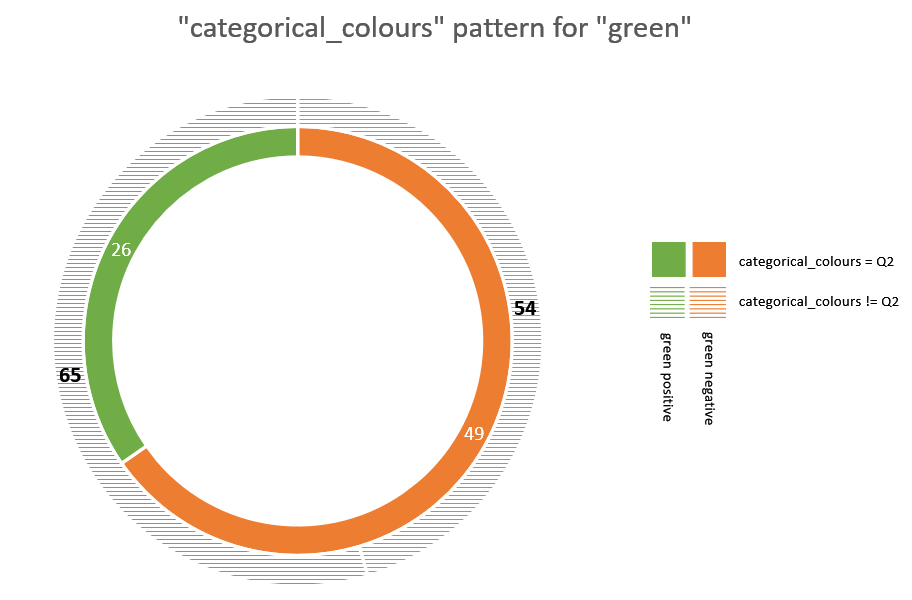

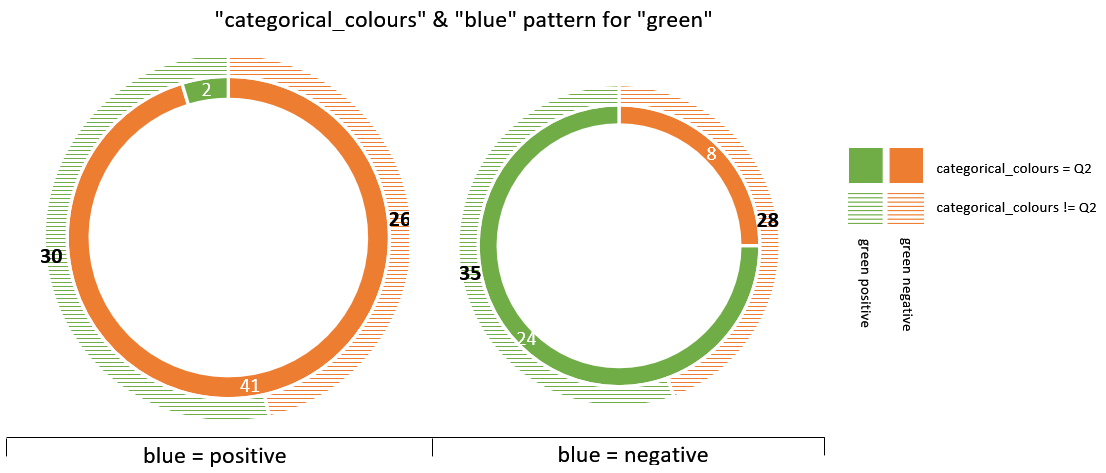

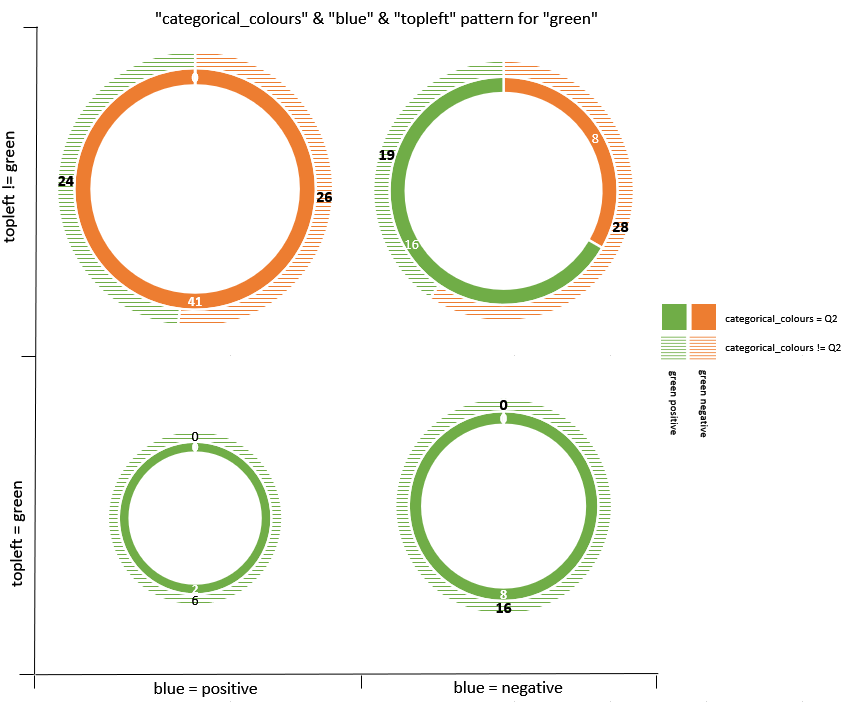